In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
release_zone = "test_1500"
number_particles = 100000
start_year = 2009
start_month = 3
start_day = 1
runtime_in_days = 42

In [6]:
SIGMA=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_child.nc')
#INALT_mask=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_dataset('../output_data/ROMS_child/Column_test_1500_20090301_RT-42_N-100000_seed-12345.nc') 
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [7]:
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})

In [8]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [9]:
release_locations = load_release_locations(release_locations_file = "../data/config/test_stations.csv")
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 1500.0)

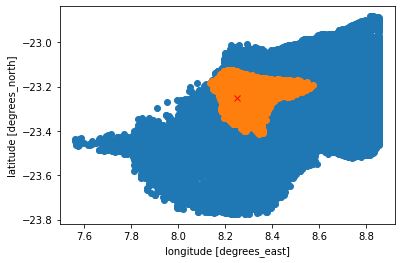

In [10]:
particle_ds.isel(obs=slice(0,16)).plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx');

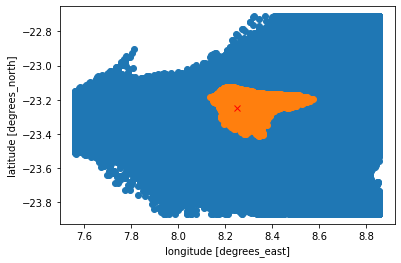

In [11]:
particle_ds.isel(obs=slice(0,42)).plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx');

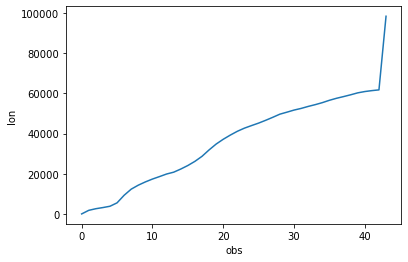

In [12]:
particle_ds.lon.isnull().sum("traj").plot()

In [13]:
traj_plot = particle_ds.isel(traj=slice(0,99999,1000), obs=slice(0,42,7))
start = traj_plot.isel(obs=0)
traj_plot

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 6)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 8.273 8.64 8.717 8.79 ... nan nan nan nan
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [14]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


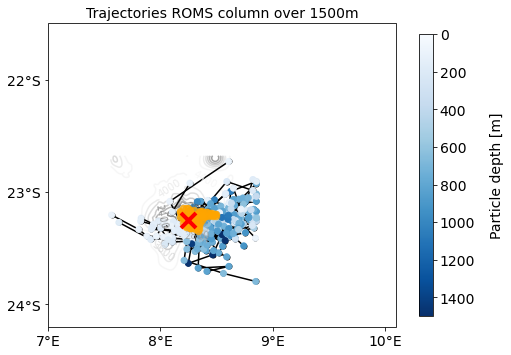

In [15]:
fig, ax = plt.subplots(1,1,figsize=(7,6),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))


#ax.coastlines(resolution='10m')
#ax.add_feature(cf.BORDERS)
#ax.add_feature(cf.LAND, facecolor='#8e9497ff')#(138, 145, 149, 1.00)
ax.set_extent([7,10.1,
               -24.2,-21.5], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)
ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',vmin=0,vmax=1500)
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
#cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
c=ax.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #ROMS
#c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],topo_INALT,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
ax.set_yticks([-22,-23.,-24])
ax.set_yticklabels(['22°S','23°S','24°S'],fontsize=14, family='Arial')

ax.set_title('Trajectories ROMS column over 1500m', fontsize = 14)

#plt.savefig(('../output_data/ROMS/plots/trajectories_column_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-12345.png').format(
#    release_zone = release_zone,
#    start_year=start_year,
#    start_month = start_month,
#    start_day = start_day,
#    runtime_in_days = runtime_in_days,
#    number_particles=number_particles)
#           )
#ax.set_xlim([7,9.8])
#ax.set_ylim([-24.2,-21.5])

plt.show()

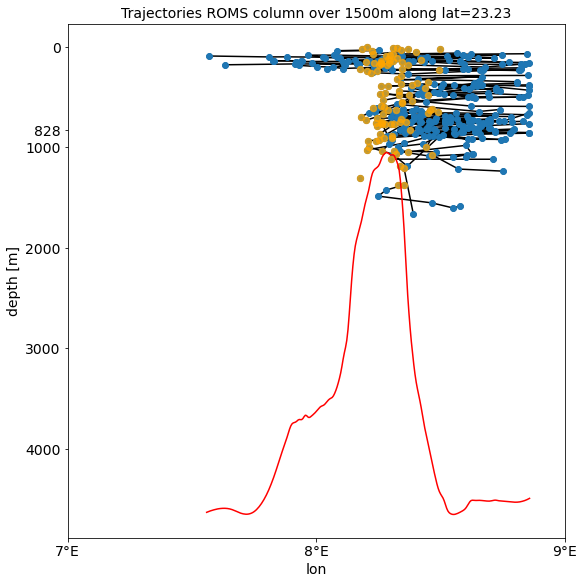

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True,
                      )


#start points
ax.scatter(start['lon'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['z'].T, zorder=2)#,c=traj_plot['z'].T,cmap='Blues')
ax.plot(traj_plot['lon'].T, traj_plot['z'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
#cb = fig.colorbar(sc,shrink=0.662)
#cb.ax.invert_yaxis()
#sc.figure.axes[1].tick_params(axis="y", labelsize=14)
#cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
#cb.ax.get_yaxis().labelpad = 15
#cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
topo_ROMS.isel(lat=129).sel( #-23.23
               lon=slice(bathymodiolus_lon-1.5,
                         bathymodiolus_lon+1,None)).plot(zorder=3, color='red')

#labels
ax.set_xticks([7,8,9])
ax.set_xticklabels(['7°E','8°E','9°E'],fontsize=14, family='Arial')
ax.set_xlabel('lon',fontsize=14, family='Arial')
ax.set_yticks([0,828,1000,2000,3000,4000])
ax.set_yticklabels(['0','828','1000','2000','3000','4000'],fontsize=14, family='Arial')
ax.set_ylabel('depth [m]',fontsize=14, family='Arial')

ax.set_title('Trajectories ROMS column over 1500m along lat=23.23', fontsize = 14)
ax.invert_yaxis()
#ax.set_xlim([6.5,9])

plt.show()

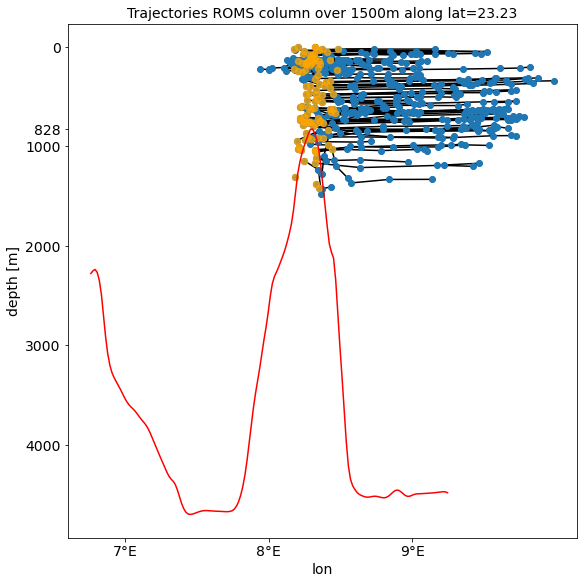

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True)

#start points
ax.scatter(start['lon'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['z'].T, zorder=2)#,c=traj_plot['z'].T,cmap='Blues')
ax.plot(traj_plot['lon'].T, traj_plot['z'].T, zorder=1, marker='o',markersize=5,color='black')

#topography lines
topo_ROMS.isel(lat=129).sel( #-23.23
               lon=slice(bathymodiolus_lon-1.5,
                         bathymodiolus_lon+1,None)).plot(zorder=3, color='red')

#labels
ax.set_xticks([7,8,9])
ax.set_xticklabels(['7°E','8°E','9°E'],fontsize=14, family='Arial')
ax.set_xlabel('lon',fontsize=14, family='Arial')
ax.set_yticks([0,828,1000,2000,3000,4000])
ax.set_yticklabels(['0','828','1000','2000','3000','4000'],fontsize=14, family='Arial')
ax.set_ylabel('depth [m]',fontsize=14, family='Arial')

ax.set_title('Trajectories ROMS column over 1500m along lat=23.23', fontsize = 14)
ax.invert_yaxis()

plt.show()

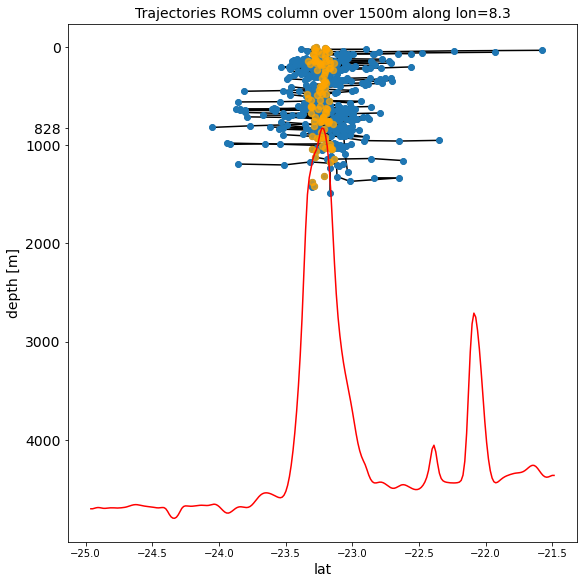

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True)

#start points
ax.scatter(start['lat'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot['lat'].T, traj_plot['z'].T, zorder=2)
ax.plot(traj_plot['lat'].T, traj_plot['z'].T, zorder=1, marker='o',markersize=5,color='black')

#topography lines
topo_ROMS.isel(lon=122).sel( #8.304117
               lat=slice(bathymodiolus_lat-3,
                         bathymodiolus_lat+3,None)).plot(zorder=3, color='red')

#labels
#ax.set_xticks([7,8,9])
#ax.set_xticklabels(['7°E','8°E','9°E'],fontsize=14, family='Arial')
ax.set_xlabel('lat',fontsize=14, family='Arial')
ax.set_yticks([0,828,1000,2000,3000,4000])
ax.set_yticklabels(['0','828','1000','2000','3000','4000'],fontsize=14, family='Arial')
ax.set_ylabel('depth [m]',fontsize=14, family='Arial')

ax.set_title('Trajectories ROMS column over 1500m along lon=8.3', fontsize = 14)
ax.invert_yaxis()

plt.show()